In [1]:
import pandas as pd
import numpy as np
import wrangle
import explore
import evaluate as ev

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from scipy import stats
from math import sqrt

import sklearn.preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression, SelectKBest, RFE

## Wrangle My Data:
- Acquire my dataframe
- Prepare/Clean my dataframe
- Address outliers
- Complete initial exploration to verify.

In [2]:
# acquire my dataframe from sql
df = wrangle.get_zillow()

In [3]:
# use my info function to find out more information
wrangle.get_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38396 entries, 0 to 38395
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    38396 non-null  float64
 1   bathroomcnt                   38396 non-null  float64
 2   calculatedfinishedsquarefeet  38288 non-null  float64
 3   taxvaluedollarcnt             38395 non-null  float64
 4   yearbuilt                     38264 non-null  float64
 5   taxamount                     38395 non-null  float64
 6   fips                          38396 non-null  float64
 7   parcelid                      38396 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 2.3 MB
None
------------------------
------------------------
This dataframe has 38396 rows and 8 columns.
------------------------
Null count in dataframe:
------------------------
bedroomcnt                        0
bathroomcnt                       0
calcu

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips,parcelid
7559,2.0,2.0,1553.0,485226.0,1958.0,5892.16,6037.0,10839379
15091,4.0,4.0,2446.0,2413290.0,1911.0,28862.40,6037.0,11587461
25111,2.0,2.0,1120.0,522853.0,1971.0,5830.94,6059.0,14699714


In [4]:
# let's put the data we just obtained 
df = wrangle.clean_zillow(df)

In [5]:
# see what's changed on my clean data
wrangle.get_info(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38226 entries, 0 to 38395
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num_bedroom    38226 non-null  float64
 1   num_bathroom   38226 non-null  float64
 2   finished_sqft  38226 non-null  float64
 3   tax_value      38226 non-null  float64
 4   build_year     38226 non-null  float64
 5   tax_amount     38226 non-null  float64
 6   fips           38226 non-null  float64
 7   state          38226 non-null  object 
 8   county         38226 non-null  object 
 9   tax_rate       38226 non-null  float64
dtypes: float64(8), object(2)
memory usage: 3.2+ MB
None
------------------------
------------------------
This dataframe has 38226 rows and 10 columns.
------------------------
Null count in dataframe:
------------------------
num_bedroom      0
num_bathroom     0
finished_sqft    0
tax_value        0
build_year       0
tax_amount       0
fips             0
st

,num_bedroom,num_bathroom,finished_sqft,tax_value,build_year,tax_amount,fips,state,county,tax_rate
34725,3.0,2.0,1524.0,509712.0,1974.0,5389.00,6111.0,California,Ventura,1.057264
18638,1.0,2.0,864.0,403000.0,1973.0,4844.66,6037.0,California,Los Angeles,1.202149
1744,3.0,2.0,1059.0,322469.0,1958.0,3932.27,6037.0,California,Los Angeles,1.219426


In [6]:
# Tells us unique count
df.nunique()

num_bedroom         13
num_bathroom        19
finished_sqft     4187
tax_value        28238
build_year         131
tax_amount       37317
fips                 3
state                1
county               3
tax_rate         38110
dtype: int64

In [7]:
column = ['num_bedroom', 'num_bathroom', 'fips']
wrangle.value_counts(df, column)

num_bedroom
3.0     15503
2.0      9685
4.0      8680
5.0      2151
1.0      1659
6.0       338
0.0       143
7.0        50
8.0         8
9.0         4
10.0        2
11.0        2
12.0        1
Name: num_bedroom, dtype: int64
-------------
num_bathroom
2.0     15827
3.0      8286
1.0      6555
2.5      3606
4.0      1336
1.5       736
3.5       594
5.0       456
4.5       385
6.0       179
5.5       111
7.0        52
0.0        30
8.0        29
6.5        27
7.5         9
9.0         5
11.0        2
10.0        1
Name: num_bathroom, dtype: int64
-------------
fips
6037.0    23989
6059.0    11068
6111.0     3169
Name: fips, dtype: int64
-------------


In [8]:
df.head()

,num_bedroom,num_bathroom,finished_sqft,tax_value,build_year,tax_amount,fips,state,county,tax_rate
0,3.0,2.0,1125.0,289445.0,1974.0,3490.16,6059.0,California,Orange,1.205811
1,3.0,2.0,1316.0,205123.0,1923.0,2627.48,6037.0,California,Los Angeles,1.280929
2,3.0,2.0,1458.0,136104.0,1970.0,2319.90,6037.0,California,Los Angeles,1.704505
3,3.0,2.0,1766.0,810694.0,1980.0,9407.01,6037.0,California,Los Angeles,1.160365
4,2.0,1.0,1421.0,35606.0,1911.0,543.69,6037.0,California,Los Angeles,1.526962


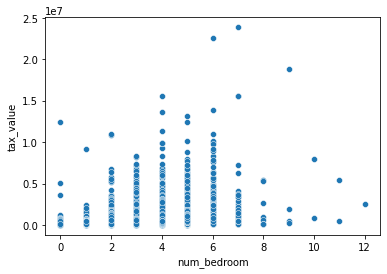

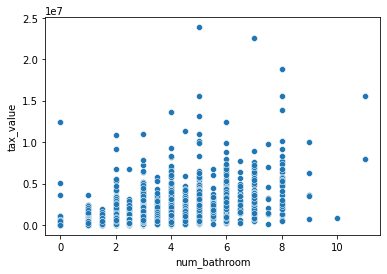

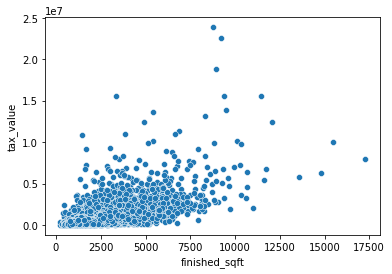

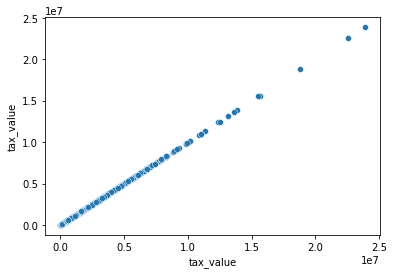

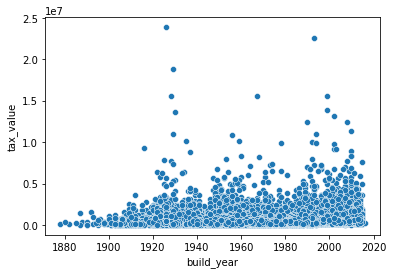

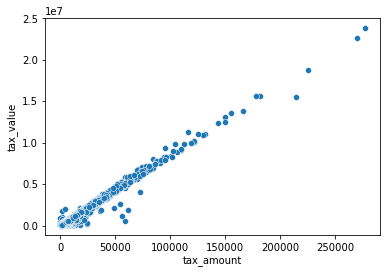

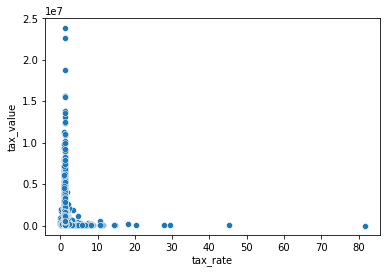

In [9]:
# visualize outliers of my numeric columns
cols = df.drop(columns=['fips', 'state', 'county'])
explore.scatterplot(cols, df.tax_value, df)

In [10]:
df.shape

(38226, 10)

In [11]:
df.head()

,num_bedroom,num_bathroom,finished_sqft,tax_value,build_year,tax_amount,fips,state,county,tax_rate
0,3.0,2.0,1125.0,289445.0,1974.0,3490.16,6059.0,California,Orange,1.205811
1,3.0,2.0,1316.0,205123.0,1923.0,2627.48,6037.0,California,Los Angeles,1.280929
2,3.0,2.0,1458.0,136104.0,1970.0,2319.90,6037.0,California,Los Angeles,1.704505
3,3.0,2.0,1766.0,810694.0,1980.0,9407.01,6037.0,California,Los Angeles,1.160365
4,2.0,1.0,1421.0,35606.0,1911.0,543.69,6037.0,California,Los Angeles,1.526962


In [12]:
# remove outliers
cols = df.drop(columns=['fips', 'state', 'county'])
df = wrangle.outlier_bounds(df, cols)
df.shape

For num_bedroom the lower bound is 0 and  upper bound is 7.0
For num_bathroom the lower bound is 0.5 and  upper bound is 4.5
For finished_sqft the lower bound is 0 and  upper bound is 3329.0
For tax_value the lower bound is 0 and  upper bound is 1031868.5
For build_year the lower bound is 1907.125 and  upper bound is 2016.0
For tax_amount the lower bound is 0 and  upper bound is 11316.872500000001
For tax_rate the lower bound is 0.8926041934509568 and  upper bound is 1.6256905756483346


(30268, 10)

In [13]:
# take a look at the dataframe with removed outliers
df.head(3)

,num_bedroom,num_bathroom,finished_sqft,tax_value,build_year,tax_amount,fips,state,county,tax_rate
0,3.0,2.0,1125.0,289445.0,1974.0,3490.16,6059.0,California,Orange,1.205811
1,3.0,2.0,1316.0,205123.0,1923.0,2627.48,6037.0,California,Los Angeles,1.280929
3,3.0,2.0,1766.0,810694.0,1980.0,9407.01,6037.0,California,Los Angeles,1.160365


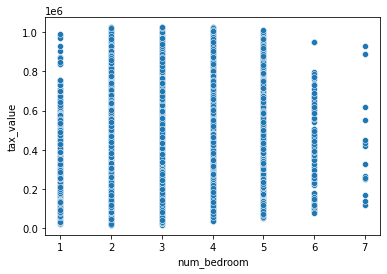

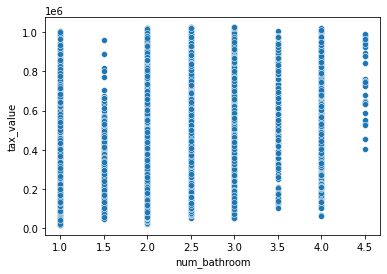

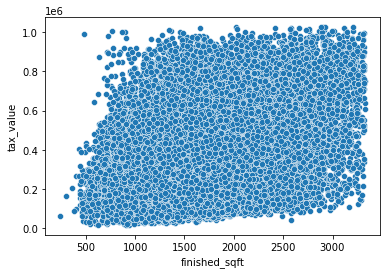

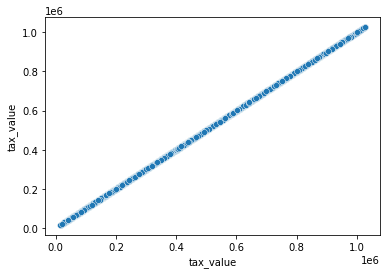

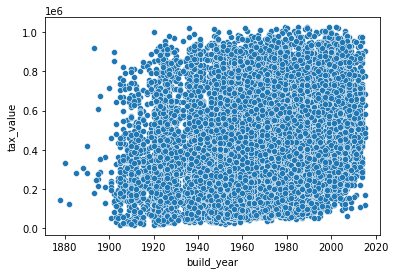

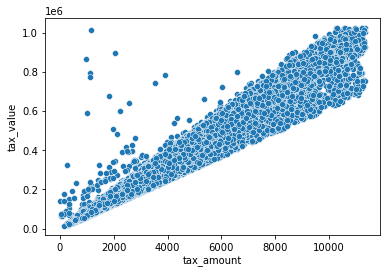

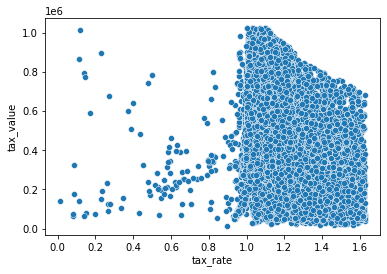

In [14]:
# visualize outliers of my numeric columns
cols = df.drop(columns=['fips', 'state', 'county'])
explore.scatterplot(cols, df.tax_value, df)

In [15]:
# take a look at clean value counts
column = ['num_bedroom', 'num_bathroom', 'fips']
wrangle.value_counts(df, column)

num_bedroom
3.0    12658
2.0     8617
4.0     6299
1.0     1540
5.0     1037
6.0      103
7.0       14
Name: num_bedroom, dtype: int64
-------------
num_bathroom
2.0    13618
3.0     6517
1.0     5437
2.5     3281
1.5      684
4.0      478
3.5      224
4.5       29
Name: num_bathroom, dtype: int64
-------------
fips
6037.0    18325
6059.0     9206
6111.0     2737
Name: fips, dtype: int64
-------------


#### Split our data into train, validate and test

In [16]:
# split data using function from wrangle.py
train, validate, test = wrangle.split_data(df)

train---> (16949, 10)
validate---> (7265, 10)
test---> (6054, 10)


In [17]:
X_train, y_train = train.drop(columns='tax_value'), train.tax_value
X_validate, y_validate = validate.drop(columns='tax_value'), validate.tax_value
X_test, y_test = test.drop(columns='tax_value'), test.tax_value

In [18]:
train.head(1)

,num_bedroom,num_bathroom,finished_sqft,tax_value,build_year,tax_amount,fips,state,county,tax_rate
31441,3.0,3.0,1820.0,562771.0,2010.0,8965.54,6037.0,California,Los Angeles,1.593106


In [19]:
#### Scale our data using MinMaxScaler function (since we addressed the outliers)
numeric_cols = ['finished_sqft', 'build_year']
X_train, X_validate, X_test = wrangle.min_max_scaler(X_train, X_validate, X_test, numeric_cols)

In [20]:
# glue our split data with our target back together for exploration
train_scaled = pd.concat(([X_train, y_train]), axis=1)
validate_scaled = pd.concat(([X_validate, y_validate]), axis=1)
test_scaled = pd.concat(([X_test, y_test]), axis=1)

In [21]:
train_scaled.head(3)

,num_bedroom,num_bathroom,finished_sqft,build_year,tax_amount,fips,state,county,tax_rate,tax_value
31441,3.0,3.0,0.502313,0.963504,8965.54,6037.0,California,Los Angeles,1.593106,562771.0
26357,2.0,2.0,0.278255,0.810219,2402.24,6059.0,California,Orange,1.000154,240187.0
33726,3.0,1.0,0.289491,0.328467,4013.24,6037.0,California,Los Angeles,1.201882,333913.0


### Acquire/Prepare Takeaways:
- I acquire my data.
- I cleaned thoroughly cleaned and prepared my data by:
 - replacing whitespaces with nans
 - dropping any duplicates and nulls
 - renamed columns
 - created columns (tax_rate, county, state)
 - addressed and removed any outliers
- Next I split my data into train, validate and test
- Lastly I scaled my data using MinMaxScaler function

## EXPLORE
- I will use my scaled train dataframe to further explore from here.
- I will visualize my correlations to point out any obvious features for my model.
- I will also conduct at least two statistics tests to assess correlation.

In [22]:
train_scaled.head()

,num_bedroom,num_bathroom,finished_sqft,build_year,tax_amount,fips,state,county,tax_rate,tax_value
31441,3.0,3.0,0.502313,0.963504,8965.54,6037.0,California,Los Angeles,1.593106,562771.0
26357,2.0,2.0,0.278255,0.810219,2402.24,6059.0,California,Orange,1.000154,240187.0
33726,3.0,1.0,0.289491,0.328467,4013.24,6037.0,California,Los Angeles,1.201882,333913.0
8591,2.0,1.0,0.227363,0.423358,6151.44,6037.0,California,Los Angeles,1.162843,529000.0
35318,2.0,1.0,0.214805,0.335766,1656.70,6059.0,California,Orange,1.408842,117593.0


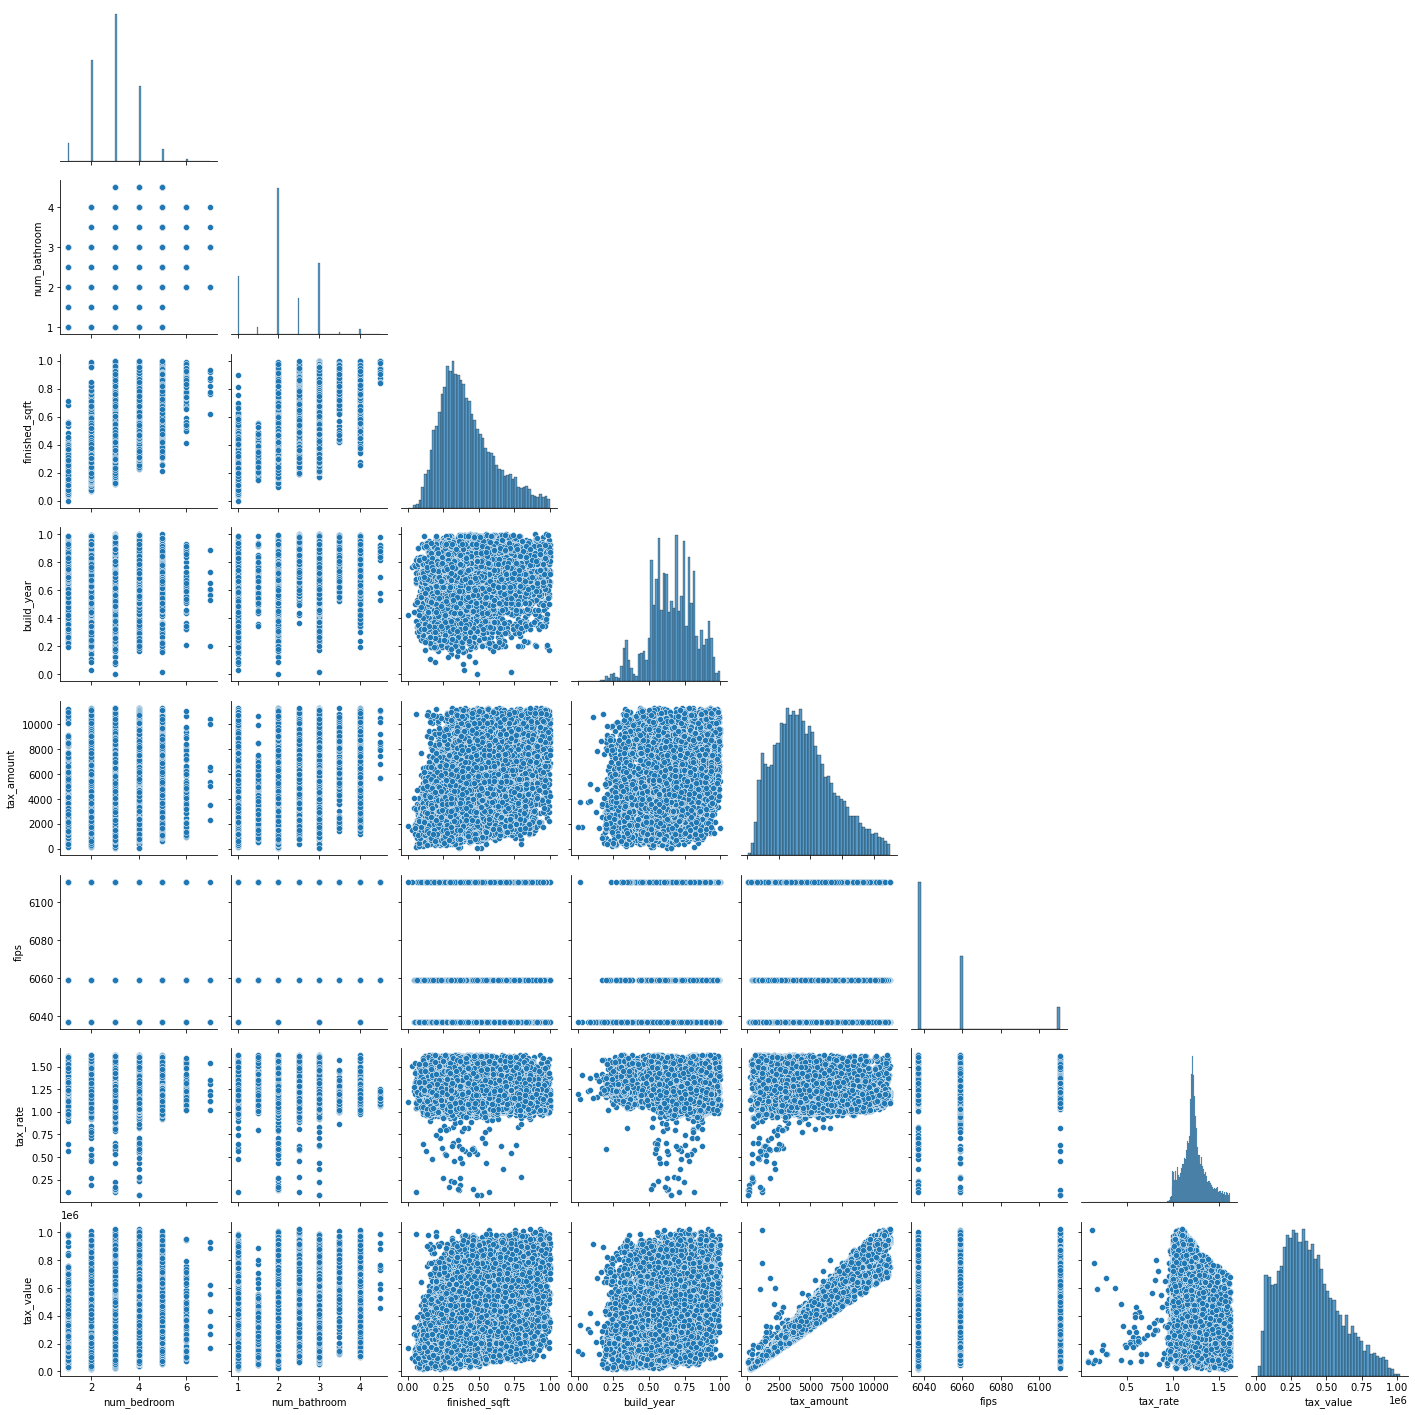

In [23]:
sns.pairplot(train_scaled, corner=True)
plt.show()

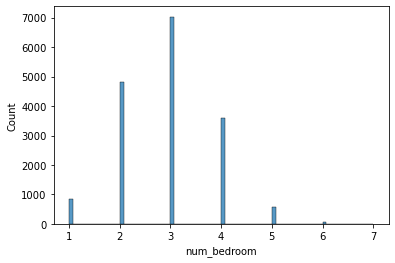

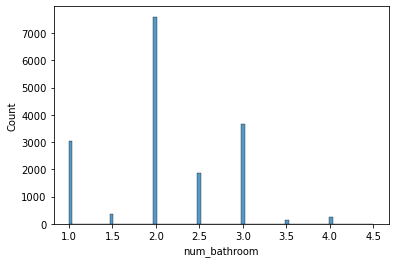

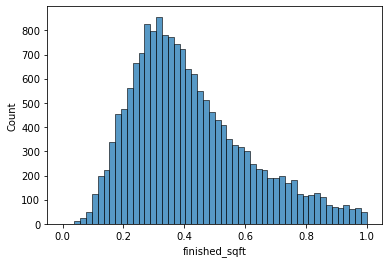

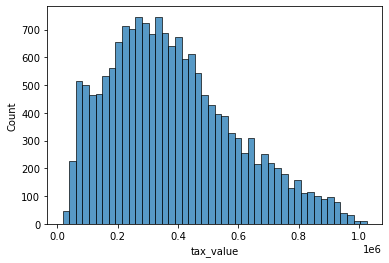

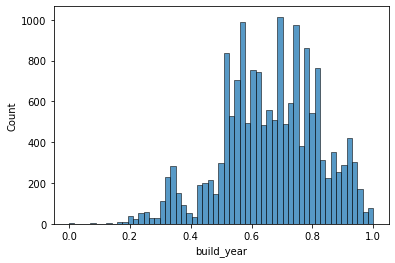

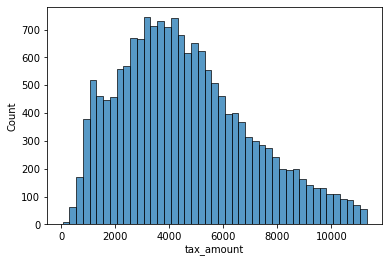

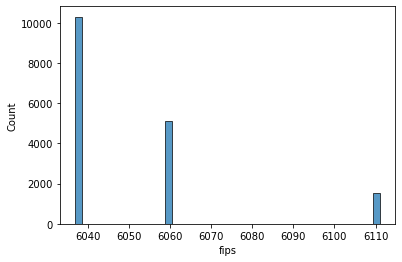

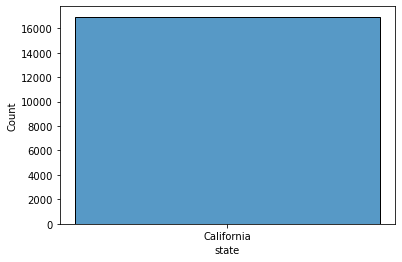

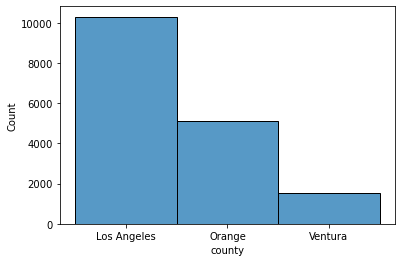

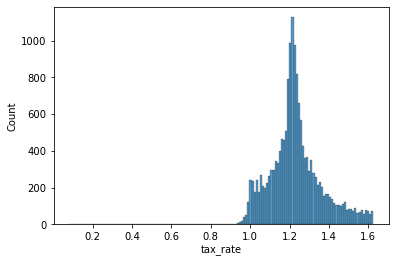

In [24]:
column = df.columns
for i in column:
    sns.histplot(data=train_scaled, x=i)
    plt.show()

<Figure size 1152x648 with 0 Axes>

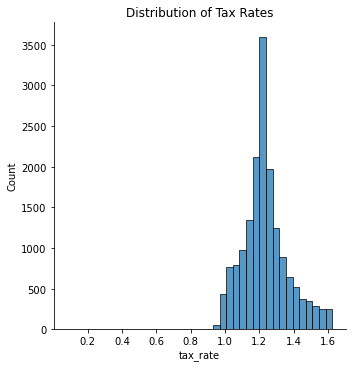

In [25]:
# visualize distributions of tax rate for the zillow team
plt.figure(figsize=(16,9))
sns.displot(train_scaled, x="tax_rate", bins=40)
# plt.ylim(-20, 100)
plt.title('Distribution of Tax Rates')
plt.show()

Text(0.5, 1.0, 'Tax Value v. Bbedrooms')

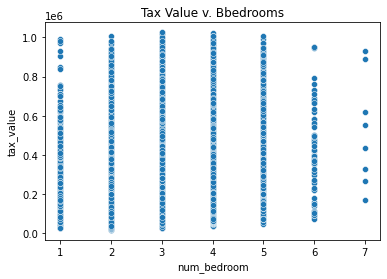

In [26]:
# visual to decide how to bin number of bedrooms
sns.scatterplot(data=train_scaled, x='num_bedroom', y='tax_value')
plt.title('Tax Value v. Bbedrooms')

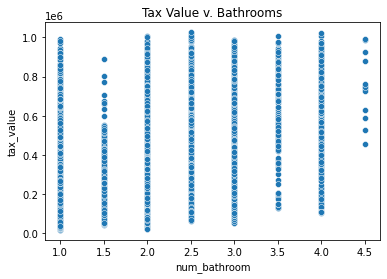

In [27]:
# visual to decide how to bin number of bathrooms
sns.scatterplot(data=train_scaled, x='num_bathroom', y='tax_value')
plt.title('Tax Value v. Bathrooms')
plt.show()

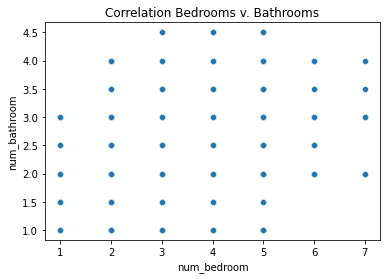

In [28]:
# do i have to bin both? or are they correlated with each other?
# this tells us we will have to bin both
sns.scatterplot(data=train_scaled, x='num_bedroom', y='num_bathroom', palette="ch:r=-.5,l=.75")
plt.title('Correlation Bedrooms v. Bathrooms')
plt.show()

In [29]:
# take a quick look at our dataframe
train_scaled.head(3)

,num_bedroom,num_bathroom,finished_sqft,build_year,tax_amount,fips,state,county,tax_rate,tax_value
31441,3.0,3.0,0.502313,0.963504,8965.54,6037.0,California,Los Angeles,1.593106,562771.0
26357,2.0,2.0,0.278255,0.810219,2402.24,6059.0,California,Orange,1.000154,240187.0
33726,3.0,1.0,0.289491,0.328467,4013.24,6037.0,California,Los Angeles,1.201882,333913.0


In [30]:
# for visual correlation purposes, I will create dummies for my state column
train_scaled = pd.get_dummies(data=train_scaled, columns=['county'])
validate_scaled = pd.get_dummies(data=validate_scaled, columns=['county'])
test_scaled = pd.get_dummies(data=test_scaled, columns=['county'])

In [31]:
train_scaled.head(3)

,num_bedroom,num_bathroom,finished_sqft,build_year,tax_amount,fips,state,tax_rate,tax_value,county_Los Angeles,county_Orange,county_Ventura
31441,3.0,3.0,0.502313,0.963504,8965.54,6037.0,California,1.593106,562771.0,1,0,0
26357,2.0,2.0,0.278255,0.810219,2402.24,6059.0,California,1.000154,240187.0,0,1,0
33726,3.0,1.0,0.289491,0.328467,4013.24,6037.0,California,1.201882,333913.0,1,0,0


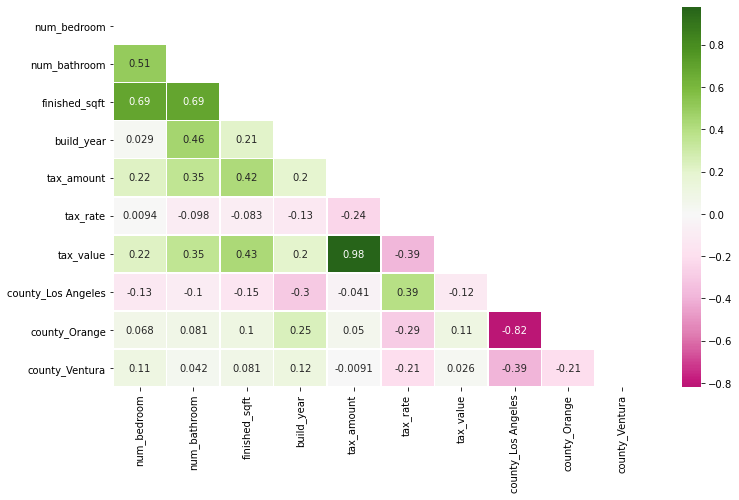

In [32]:
# Take a look at a correlation heatmap
numerical = train_scaled.drop(columns=['fips', 'state'])
corr = numerical.corr()
plt.figure(figsize=(12,7))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, center=0, annot=True, linewidths=.5, cmap="PiYG", mask=mask)
plt.show()

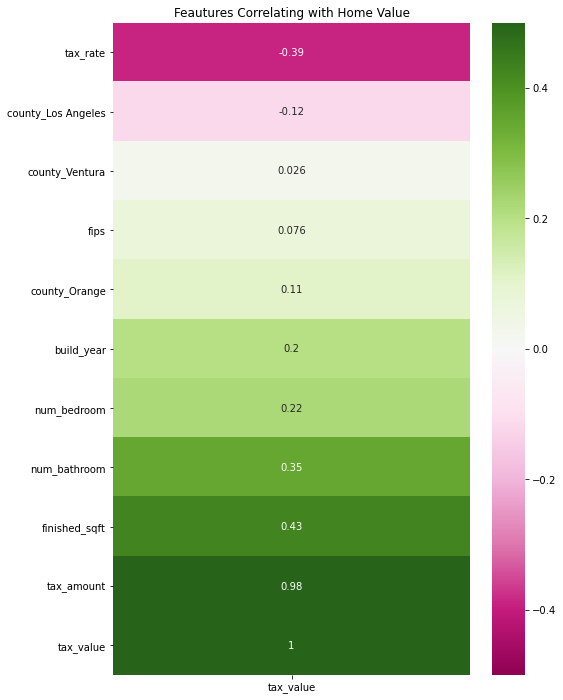

In [33]:
# Take a look at a heatmap of correlation to tax value
plt.figure(figsize=(8,12))
value_heatmap = sns.heatmap(train_scaled.corr()[['tax_value']].sort_values(by='tax_value', ascending=True), cmap="PiYG", vmin=-.5, vmax=.5, annot=True)
value_heatmap.set_title('Feautures Correlating with Home Value')
plt.show()

### Hypothesis Testing

I want to conduct a few statistics tests to confirm or deny correlations between variables.

In [34]:
# take a quick look at our continous variables
train_scaled.head(2)

,num_bedroom,num_bathroom,finished_sqft,build_year,tax_amount,fips,state,tax_rate,tax_value,county_Los Angeles,county_Orange,county_Ventura
31441,3.0,3.0,0.502313,0.963504,8965.54,6037.0,California,1.593106,562771.0,1,0,0
26357,2.0,2.0,0.278255,0.810219,2402.24,6059.0,California,1.000154,240187.0,0,1,0


We already know finished squarefeet is highly correlated to tax value.\
It's worth taking a look at correlation between build year and tax value.\
Since square feet is continuous, we can use the pearson r test to assess correlation to tax value.


##### Set our hypothesis:
${H_0}$ = There is no linear correlation between finished squarefeet and tax value of a house.\
${H_a}$ = There is a linear correlation between finished squarefeet and tax value of a house.

In [35]:
# set our confidence level
conf_int = .95

# assign our alpha based on confidence level
alpha = 1 - conf_int

# utilize the stats pearsonr method
corr, p = stats.pearsonr(train_scaled.finished_sqft, train_scaled.tax_value)

if p < alpha:
    print(f'''Correlation is :{corr}
p value is {p}
We reject our null hypothesis that finished squarefeet and tax value have no linear correlation.
There is evidence to support there is a linear correlation.''')
if p > alpha:
    print(f'We cannot reject the null hypothesis')

Correlation is :0.42751427949089066
p value is 0.0
We reject our null hypothesis that finished squarefeet and tax value have no linear correlation.
There is evidence to support there is a linear correlation.


To confirm that my plan of binning the bedrooms is a good approach, I will next conduct a t-test to assess whether there may be correlation in bedroom count to tax value. I will use a two sample one tailed test to compare to sample means.

##### Set our hypothesis:
${H_0}$ = The mean of tax value for 1-3 bedroom homes == the mean of tax value for 4+ bedrooms home.\
${H_a}$ =The mean of tax value for 1-3 bedroom homes < the mean of tax value for 4+ bedrooms home.

In [36]:
# set our confidence level
conf_int = .95

# assign our alpha based on confidence level
alpha = 1 - conf_int

# set up my samples
sample1 = train_scaled[train_scaled['num_bedroom']<4].tax_value
sample2 = train_scaled[train_scaled['num_bedroom']>3].tax_value

In [37]:
# let's check the variance to confirm equality
sample1.var(), sample2.var()

(38484855547.502884, 52526707716.75918)

In [38]:
# there is quite a difference so we will set equal_var to false
t, p = stats.ttest_ind(sample1, sample2, equal_var=False)

if (p/2 < alpha) & (t > 0):
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

We fail to reject the null hypothesis


So since we fail to reject ${H_0}$, there is reason to believe the mean of tax value of more bedroom homes is the same as lesser bedroom homes. This confirms that binning the bedrooms column will not affect my model negatively.

### Explore Takeaways:
- Visualizing my data helped me confirm/deny many correlations.
- I was able to see that most of my data is normally distributed.
- Interestingly, there is no visual correlation between number of bedrooms or number of bathrooms on tax value.
- Additionally, there is no correlation of bedrooms to bathrooms either. This helps my decide how to bin my data.
- The heatmap helped me rule out a few features that likely will not make it to my model.
- The statistics tests also helped me assess the suspicions of correlation I had with number of bedrooms and square footage on tax value.

## Model
- Exploration helped me decide how to bin my bedrooms/bathrooms column moving forward.
- I will create a baseline model and compare to other models to see which performs the best.

In [39]:
# let's go ahead and bin the columns like I mentioned above.
train_scaled.head()

,num_bedroom,num_bathroom,finished_sqft,build_year,tax_amount,fips,state,tax_rate,tax_value,county_Los Angeles,county_Orange,county_Ventura
31441,3.0,3.0,0.502313,0.963504,8965.54,6037.0,California,1.593106,562771.0,1,0,0
26357,2.0,2.0,0.278255,0.810219,2402.24,6059.0,California,1.000154,240187.0,0,1,0
33726,3.0,1.0,0.289491,0.328467,4013.24,6037.0,California,1.201882,333913.0,1,0,0
8591,2.0,1.0,0.227363,0.423358,6151.44,6037.0,California,1.162843,529000.0,1,0,0
35318,2.0,1.0,0.214805,0.335766,1656.70,6059.0,California,1.408842,117593.0,0,1,0


In [40]:
# Here I bin my data and separate columns for houses with 3 or less bedrooms and 4 or more bedrooms
# For bathrooms I bin them as 2.5 or less bathroom homes and 3 or more bathroom homes.

train_scaled['three_bed_less'] = np.where(train_scaled['num_bedroom']<4,1,0)
train_scaled['four_bed_more'] = np.where(train_scaled['num_bedroom']>3,1,0)

validate_scaled['three_bed_less'] = np.where(validate_scaled['num_bedroom']<4,1,0)
validate_scaled['four_bed_more'] = np.where(validate_scaled['num_bedroom']>3,1,0)

test_scaled['three_bed_less'] = np.where(test_scaled['num_bedroom']<4,1,0)
test_scaled['four_bed_more'] = np.where(test_scaled['num_bedroom']>3,1,0)

# ---------

train_scaled['twohalf_bath_less'] = np.where(train_scaled['num_bathroom']<3,1,0)
train_scaled['three_bath_more'] = np.where(train_scaled['num_bathroom']>=3,1,0)

validate_scaled['twohalf_bath_less'] = np.where(validate_scaled['num_bathroom']<3,1,0)
validate_scaled['three_bath_more'] = np.where(validate_scaled['num_bathroom']>=3,1,0)

test_scaled['twohalf_bath_less'] = np.where(test_scaled['num_bathroom']<3,1,0)
test_scaled['three_bath_more'] = np.where(test_scaled['num_bathroom']>=3,1,0)

In [41]:
# confirm there are no strings
train_scaled.dtypes

num_bedroom           float64
num_bathroom          float64
finished_sqft         float64
build_year            float64
tax_amount            float64
fips                  float64
state                  object
tax_rate              float64
tax_value             float64
county_Los Angeles      uint8
county_Orange           uint8
county_Ventura          uint8
three_bed_less          int64
four_bed_more           int64
twohalf_bath_less       int64
three_bath_more         int64
dtype: object

In [42]:
# let's split our data back into x and y for modeling.
# Since tax_value is our ytarget and tax_amount as well as tax_rate are directly correlated to our ytarget,
# I will drop all of these from my model features so that I can get an accurate RMSE
# I also want to drop all object columns and duplicate columns from our model so that we only utilize what is necessary

cols = ['tax_amount', 'tax_rate', 'tax_value', 'num_bedroom', 'num_bathroom', 'fips', 'state', 'county_Orange']

X_train = train_scaled.drop(columns=cols)
y_train = train_scaled.tax_value

X_validate = validate_scaled.drop(columns=cols)
y_validate = validate_scaled.tax_value

X_test = test_scaled.drop(columns=cols)
y_test = test_scaled.tax_value

In [43]:
type(y_train)

pandas.core.series.Series

#### Create a baseline model

In [44]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict tax value_baseline mean
baseline_mean = y_train['tax_value'].mean()
y_train['baseline_mean'] = baseline_mean
y_validate['baseline_mean'] = baseline_mean

# 2. compute tax value baseline median
baseline_median = y_train['tax_value'].median()
y_train['baseline_median'] = baseline_median
y_validate['baseline_median'] = baseline_median

# 3. RMSE of tax_value_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.baseline_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.baseline_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of tax_value_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.baseline_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.baseline_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  208415.48 
Validate/Out-of-Sample:  208512.46
RMSE using Median
Train/In-Sample:  210485.59 
Validate/Out-of-Sample:  210029.1


What an awful baseline model! Hopefully we can create better models.

In [45]:
# now drop columns I just added so I can attempt to create better models.
y_train = train_scaled.tax_value
y_validate = validate_scaled.tax_value

# make them into dataframes again
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [46]:
# Before we jump into our own models, let's take a look at some of our best features using my pre-made functions
X_train.head(3)

,finished_sqft,build_year,county_Los Angeles,county_Ventura,three_bed_less,four_bed_more,twohalf_bath_less,three_bath_more
31441,0.502313,0.963504,1,0,1,0,0,1
26357,0.278255,0.810219,0,0,1,0,1,0
33726,0.289491,0.328467,1,0,1,0,1,0


In [47]:
# use my select_kbest function
no_features = 3
ev.select_kbest(X_train, y_train, no_features)

Index(['finished_sqft', 'twohalf_bath_less', 'three_bath_more'], dtype='object')

In [48]:
ev.rfe(X_train, y_train, no_features)

Index(['finished_sqft', 'build_year', 'four_bed_more'], dtype='object')

We can definitely see our top feature is square feet.

#### Choose best model features.

In [49]:
# Now I will choose my best features for my X_train
best_features = ['finished_sqft', 'build_year', 'three_bed_less', 'four_bed_more', 'twohalf_bath_less', 'three_bath_more']

X_train = X_train[best_features]
X_validate = X_validate[best_features]
X_train.head(3)

,finished_sqft,build_year,three_bed_less,four_bed_more,twohalf_bath_less,three_bath_more
31441,0.502313,0.963504,1,0,0,1
26357,0.278255,0.810219,1,0,1,0
33726,0.289491,0.328467,1,0,1,0


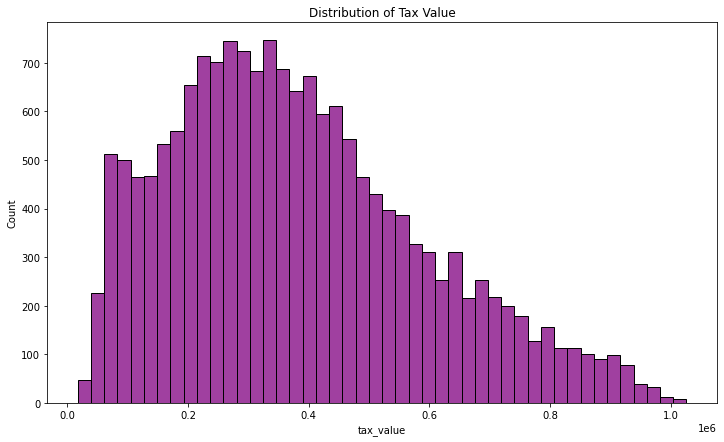

In [50]:
# Let's take a second look at the distribution of our target so we can get a better idea on the type of algorithm we want to use
plt.figure(figsize=(12,7))
sns.histplot(data=train_scaled, x=train_scaled.tax_value, color='purple')
plt.title('Distribution of Tax Value')
plt.show()

This graph resembles more of a poisson distribution which leads me to want to go with a generalized linear model from the start.\
We'll start with tht and go from there.

### TweedieRegressor Model (GLM1)

In [51]:
# first try the TweedieRegressor with power 1 for poisson distribution

glm = TweedieRegressor(power=1, alpha=0)

# fit model only to train df
glm.fit(X_train, y_train)

# create a column of predictions for comparison
y_train['glm1'] = glm.predict(X_train)

rmse_train = mean_squared_error(y_train.tax_value, y_train.glm1)**(1/2)

# -------------- 

# establish prediction column for validate
y_validate['glm1'] = glm.predict(X_validate)

rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.glm1)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  186562.4648636441 
Validation/Out-of-Sample:  186286.43629157837


### TweedieRegressor (GLM2)

In [52]:
# now drop columns I just added so I can attempt to create better models.
y_train = train_scaled.tax_value
y_validate = validate_scaled.tax_value

# make them into dataframes again
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)


glm = TweedieRegressor(power=0, alpha=0)

# fit model only to train df
glm.fit(X_train, y_train)

# create a column of predictions for comparison
y_train['glm2'] = glm.predict(X_train)

rmse_train = mean_squared_error(y_train.tax_value, y_train.glm2)**(1/2)

# -------------- 

# establish prediction column for validate
y_validate['glm2'] = glm.predict(X_validate)

rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.glm2)**(1/2)

print("RMSE for GLM using Tweedie, power=0 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=0 & alpha=0
Training/In-Sample:  186393.4593311503 
Validation/Out-of-Sample:  186196.703012233


In [53]:
X_train.head()

,finished_sqft,build_year,three_bed_less,four_bed_more,twohalf_bath_less,three_bath_more
31441,0.502313,0.963504,1,0,0,1
26357,0.278255,0.810219,1,0,1,0
33726,0.289491,0.328467,1,0,1,0
8591,0.227363,0.423358,1,0,1,0
35318,0.214805,0.335766,1,0,1,0


In [54]:
y_train.head(3)

,tax_value,glm2
31441,562771.0,482281.549550
26357,240187.0,342143.392134
33726,333913.0,280264.314840


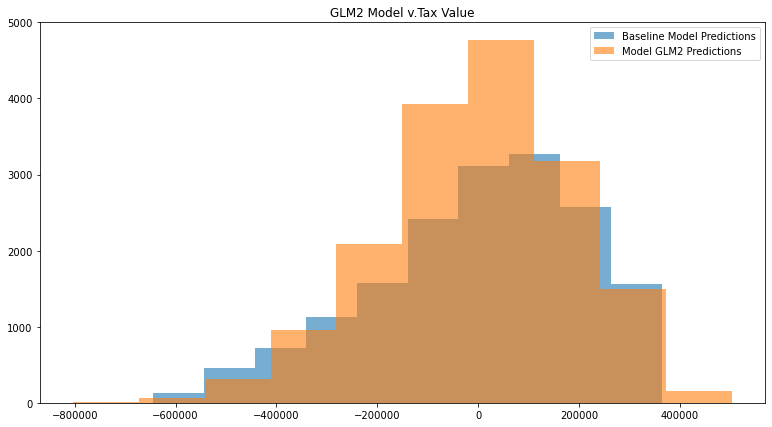

In [55]:
# let's take a look at the graph of residuals for the baseline model

# create a residual column
X_train['residual'] = (y_train.glm2 - y_train.tax_value)

# create a residual baseline column
X_train['residual_mean_baseline'] = (y_train.tax_value.mean() - y_train.tax_value)
    
fig, ax = plt.subplots(figsize=(13,7))

ax.hist(X_train.residual_mean_baseline, label='Baseline Model Predictions', alpha=.6)
# ax.hist(X_train.residual_median_baseline, label='baseline median residuals', alpha=.6)
ax.hist(X_train.residual, label='Model GLM2 Predictions', alpha=.6)
ax.legend()

plt.title('GLM2 Model v.Tax Value')
plt.show()

By the graph we can see the mean of my model's predictions is closer to 0 than that of the baseline model.

<Figure size 1152x648 with 0 Axes>

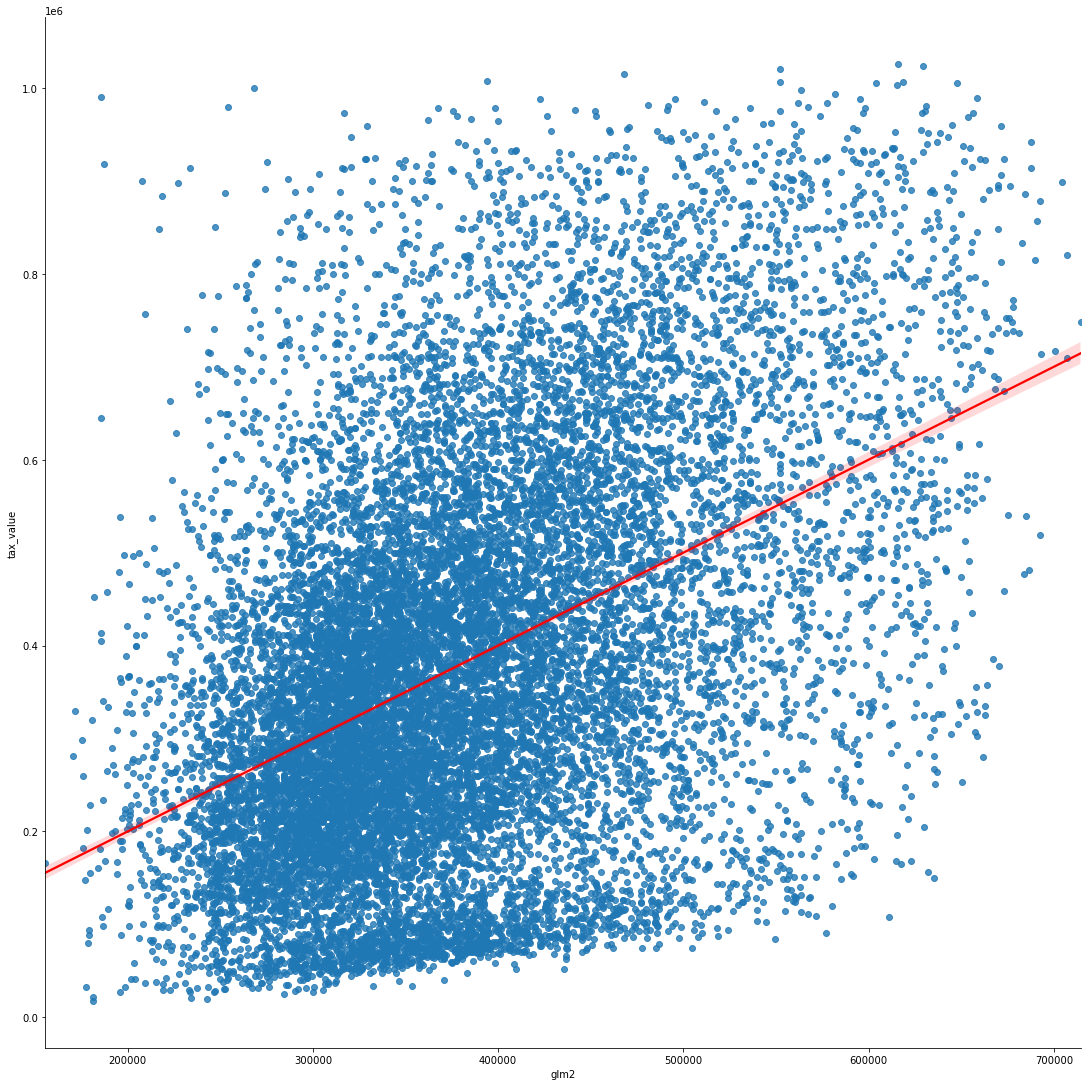

In [56]:
plt.figure(figsize=(16,9))
sns.lmplot(x='glm2', y='tax_value', data=y_train, line_kws={'color': 'red'}, size=15)
plt.show()

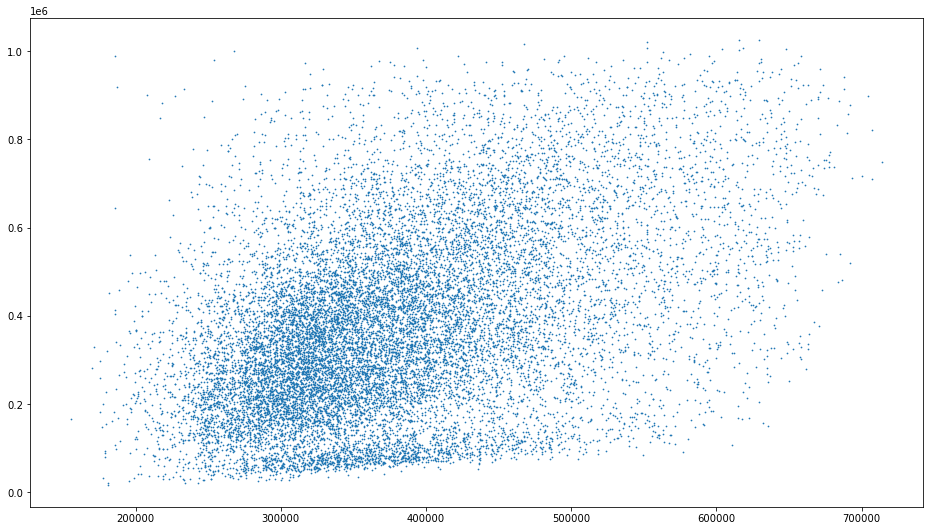

In [57]:
plt.figure(figsize=(16,9))
plt.scatter(x=y_train.glm2, y=y_train.tax_value, s=.5)
plt.show()

#### Test my Model

In [58]:
y_test = pd.DataFrame(y_test)

# fit model only to train df
glm.fit(X_train, y_train.tax_value)



# establish prediction column for test set
y_test['glm2'] = glm.predict(X_test)

rmse_test = mean_squared_error(y_test.tax_value, y_test.glm2)**(1/2)

print("RMSE for GLM using Tweedie, power=0 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
     "\nTest/Out-of-Sample: ", rmse_test)

RMSE for GLM using Tweedie, power=0 & alpha=0
Training/In-Sample:  186393.4593311503 
Validation/Out-of-Sample:  186196.703012233 
Test/Out-of-Sample:  208920.4860754989


### Distriution Tax Rates by County

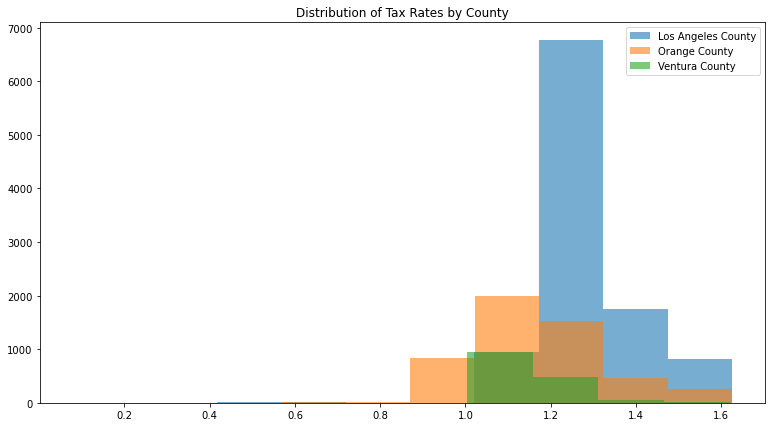

In [59]:
la = train[train['county']=='Los Angeles']
ora = train[train['county']=='Orange']
ven = train[train['county']=='Ventura']


fig, ax = plt.subplots(figsize=(13,7))

ax.hist(la.tax_rate, label='Los Angeles County', alpha=.6) # alpha=transparancy
ax.hist(ora.tax_rate, label='Orange County', alpha=.6)
ax.hist(ven.tax_rate, label='Ventura County', alpha=.6)
plt.title('Distribution of Tax Rates by County')
ax.legend()

plt.show()

## Model Takeaways
- Visualizations, statistical testing and utilizing feature engineering helped me pinpoint the best features for my model.
- My baseline wasn't too horrible and gave us a variance of 210,000 roughly.
- My GLM1 and GLM2 performed the best and have a lower variance from the regressor line.
- Both my GLM models outperformed my baseline.

# Conclusion:
- I acquired and prepped my data accordingly by addressing nulls and outliers.
- I was able to explore my data to help me bin columns to enhance my model's features.
- Statistical testing helped support the removal and addition of columns for my features.
- In the end my GLM TweedieRegressor Models performed the best and outperformed my baseline by over 20,000.
- Sadly, the model ended up performing similarly to my baseline models on unseen data.

#### With more time:
- I would conduct a lot more statistical testing to be sure I binned my data correctly.
- Adjust the amount of my features used in my model to see which helps my model perform better.
- Dive thoroughly into why my model did not test as well.
- Take a deeper at additional features such as garages and pools to see if they help my model perform better.